# SARS-CoV-2 section of manuscript

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels
import glob

# Suppress FutureWarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# SMEAGOL imports
import smeagol.io, smeagol.models, smeagol.scan, smeagol.enrich, smeagol.visualize, smeagol.variant

## Read genome, PWMs, sites, and enrichment

In [2]:
genome_file='../DATA/Genomes/Genomes/IV/Monopartite/Coronaviridae/GCF_009858895.2/GCF_009858895.2_ASM985889v3_genomic.fna.gz'
genome = smeagol.io.read_fasta(genome_file)

Read 1 records from ../DATA/Genomes/Genomes/IV/Monopartite/Coronaviridae/GCF_009858895.2/GCF_009858895.2_ASM985889v3_genomic.fna.gz


In [3]:
pwm_file='../DATA/PWMs/attract_rbpdb_encode_filtered_human_pwms.h5'
pwms = pd.read_hdf(pwm_file, key="data")
print(len(pwms))
print(len(set(pwms.Gene_name)))

362
146


In [ ]:
# Representative PWMs
reps = list(pd.read_csv('../DATA/PWMs/attract_rbpdb_encode_representative_matrices.txt', header=None)[0])

In [4]:
sites = pd.read_csv('../RESULTS/sites_attract_rbpdb_encode_filtered_human_pwms.tsv', sep='\t')
sites = sites.merge(pwms.loc[:, ['Matrix_id', 'Gene_name', 'source']])

In [5]:
all_enr = pd.read_csv('../RESULTS/genome_enrichment_results.tsv', sep='\t')
pre_len = len(all_enr)
all_enr = all_enr.merge(pwms.loc[:, ['Matrix_id', 'Gene_name', 'source']])
assert len(all_enr) == pre_len

all_enr['sig05'] = all_enr.fdr<.05
all_enr['sig1'] = all_enr.fdr<.1
all_enr['dir'] = (all_enr.num > all_enr.avg).map({True: 'up', False: 'dn'})
all_enr['fc'] = all_enr.num/all_enr.avg
all_enr['log2fc'] = np.log2(all_enr.fc)

enr = all_enr[all_enr.assembly=='GCF_009858895.2'].reset_index(drop=True)
cov_enr = all_enr[(all_enr.family == 'Coronaviridae') & \
                  (all_enr.assembly!='GCF_009858895.2')].reset_index(drop=True)

/Users/avantika/Desktop/viruslandscape/vir2/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
uenr = pd.read_csv('../RESULTS/utr_enrichment_results.tsv', sep='\t')
uenr = uenr[uenr.assembly == 'GCF_009858895.2']
uenr['sig05'] = uenr.fdr<.05
uenr['sig1'] = uenr.fdr<.1
uenr['dir'] = (uenr.num > uenr.avg).map({True: 'up', False: 'dn'})
uenr['fc'] = uenr.num/uenr.avg
uenr['log2fc'] = np.log2(uenr.fc)

/Users/avantika/Desktop/viruslandscape/vir2/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Binding sites (threshold 0.8)

In [9]:
sites.sense.value_counts()

-    23675
+    22578
Name: sense, dtype: int64

In [10]:
# How many RBPs are predicted to bind?
pos_bound_rbps = set(sites.Gene_name[sites.sense=='+'])
neg_bound_rbps = set(sites.Gene_name[sites.sense=='-'])
all_bound_rbps = set(sites.Gene_name)
print("RBPs predicted to bind to the + strand: {}\n".format(len(pos_bound_rbps)), 
      "RBPs predicted to bind to the - strand: {}\n".format(len(neg_bound_rbps)), 
      "RBPs predicted to bind to either strand: {}\n".format(len(all_bound_rbps)))

RBPs predicted to bind to the + strand: 144
 RBPs predicted to bind to the - strand: 143
 RBPs predicted to bind to either strand: 144



In [11]:
# Which RBPs have the most sites on the + strand?
sites.loc[sites.sense=='+', ['Matrix_id', 'Gene_name']].value_counts().head()

Matrix_id  Gene_name
s38        HNRNPL       1159
75         PPIE         1150
s4         CELF2         666
1174       KHDRBS3       616
64         NOVA1         600
dtype: int64

In [12]:
# How many sites and RBPs are predicted for the UTRs?
usites = pd.read_csv('../RESULTS/gpIV_utr_sites.tsv', sep='\t')
usites = usites[usites.genome_file == 'GCF_009858895.2_ASM985889v3_genomic.fna.gz']
print("Number of sites on the 5'UTR: {}\n".format(len(usites[usites.region=='five_prime_UTR'])), 
      "RBPs predicted to bind to the 5'UTR: {}\n".format(len(set(usites.Gene_name[usites.region=='five_prime_UTR']))),
      "Number of sites on the 3'UTR: {}\n".format(len(usites[usites.region=='three_prime_UTR'])), 
      "RBPs predicted to bind to the 3'UTR: {}\n".format(len(set(usites.Gene_name[usites.region=='three_prime_UTR']))))

Number of sites on the 5'UTR: 187
 RBPs predicted to bind to the 5'UTR: 63
 Number of sites on the 3'UTR: 423
 RBPs predicted to bind to the 3'UTR: 70



## Enrichment

In [13]:
print("Significant motifs: {}\n".format(len(set(enr.Matrix_id[enr.sig05]))),
      "Significant RBPs: {}\n".format(len(set(enr.Gene_name[enr.sig05]))))

Significant motifs: 89
 Significant RBPs: 65



In [14]:
# How many enriched and depleted RBPs on each strand?
enr.loc[enr.sig05, ['Gene_name', 'sense', 'dir']].drop_duplicates().iloc[:, 1:].value_counts()

sense  dir
+      dn     32
       up     18
-      up     14
       dn     13
dtype: int64

In [16]:
print("Significant motifs in UTRs: {}\n".format(sum(uenr.sig05)),
      "Significant RBPs in UTRs: {}\n".format(len(set(uenr.RBP[uenr.sig05]))))

Significant motifs in UTRs: 9
 Significant RBPs in UTRs: 9



## Define enriched sets

In [18]:
pos_up = set(enr.Gene_name[(enr.sense == '+') & (enr.sig05) & (enr.dir == 'up')])
neg_up = set(enr.Gene_name[(enr.sense == '-') & (enr.sig05) & (enr.dir == 'up')])
pos_dn = set(enr.Gene_name[(enr.sense == '+') & (enr.sig05) & (enr.dir == 'dn')])
neg_dn = set(enr.Gene_name[(enr.sense == '-') & (enr.sig05) & (enr.dir == 'dn')])

f_up=set(uenr.RBP[(uenr.region=='five_prime_UTR') & (uenr.dir == 'up') & (uenr.sig05)])
t_up=set(uenr.RBP[(uenr.region=='three_prime_UTR') & (uenr.dir == 'up') & (uenr.sig05)])
f_dn=set(uenr.RBP[(uenr.region=='five_prime_UTR') & (uenr.dir == 'dn') & (uenr.sig05)])
t_dn=set(uenr.RBP[(uenr.region=='three_prime_UTR') & (uenr.dir == 'dn') & (uenr.sig05)])

pos_up1 = set(enr.Gene_name[(enr.sense == '+') & (enr.fdr<0.1) & (enr.dir == 'up')])
neg_up1 = set(enr.Gene_name[(enr.sense == '-') & (enr.fdr<0.1) & (enr.dir == 'up')])
pos_dn1 = set(enr.Gene_name[(enr.sense == '+') & (enr.fdr<0.1) & (enr.dir == 'dn')])
neg_dn1 = set(enr.Gene_name[(enr.sense == '-') & (enr.fdr<0.1) & (enr.dir == 'dn')])

f_up1=set(uenr.RBP[(uenr.region=='five_prime_UTR') & (uenr.dir == 'up') & (uenr.fdr<.1)])
t_up1=set(uenr.RBP[(uenr.region=='three_prime_UTR') & (uenr.dir == 'up') & (uenr.fdr<.1)])
f_dn1=set(uenr.RBP[(uenr.region=='five_prime_UTR') & (uenr.dir == 'dn') & (uenr.fdr<.1)])
t_dn1=set(uenr.RBP[(uenr.region=='three_prime_UTR') & (uenr.dir == 'dn') & (uenr.fdr<.1)])

all_pos_up = pos_up.union(f_up).union(t_up)
all_up = all_pos_up.union(neg_up)
all_dn = pos_dn.union(f_dn).union(t_dn).union(neg_dn)

all_pos_up1 = pos_up1.union(f_up1).union(t_up1)
all_up1 = all_pos_up1.union(neg_up1)
all_dn1 = pos_dn1.union(f_dn1).union(t_dn1).union(neg_dn1)

print("Enriched:")
print("In + : {} ".format(len(pos_up)), 
      "In -: {} ".format(len(neg_up)), 
      "In 5'UTR: {} ".format(len(f_up)), 
      "In 3'UTR: {} ".format(len(t_up)), 
      "In all + : {} ".format(len(all_pos_up)), 
      "In all: {} \n".format(len(all_up)))
print("Depleted:")
print("In + : {} ".format(len(pos_dn)), 
      "In -: {} ".format(len(neg_dn)), 
      "In 5'UTR: {} ".format(len(f_dn)), 
      "In 3'UTR: {}".format(len(t_dn)), 
      "In all: {}\n".format(len(all_dn)))

print("Enriched at FDR .1:")
print("In + : {} ".format(len(pos_up1)), 
      "In -: {} ".format(len(neg_up1)), 
      "In 5'UTR: {} ".format(len(f_up1)), 
      "In 3'UTR: {} ".format(len(t_up1)), 
      "In all + : {} ".format(len(all_pos_up1)), 
      "In all: {}\n".format(len(all_up1)))
print("Depleted at FDR .1:")
print("In + : {} ".format(len(pos_dn1)), 
      "In -: {} ".format(len(neg_dn1)), 
      "In 5'UTR: {} ".format(len(f_dn1)), 
      "In 3'UTR: {}".format(len(t_dn1)), 
      "In all: {}\n".format(len(all_dn1)))

Enriched:
In + : 18  In -: 14  In 5'UTR: 1  In 3'UTR: 8  In all + : 22  In all: 32 

Depleted:
In + : 32  In -: 13  In 5'UTR: 0  In 3'UTR: 0 In all: 44

Enriched at FDR .1:
In + : 23  In -: 17  In 5'UTR: 1  In 3'UTR: 8  In all + : 27  In all: 37

Depleted at FDR .1:
In + : 40  In -: 16  In 5'UTR: 0  In 3'UTR: 0 In all: 54



In [19]:
# Differences between + and -
print(set(pos_up).difference(neg_up))
print(set(neg_up).difference(pos_up))
print(set(pos_dn).difference(neg_dn))
print(set(neg_dn).difference(pos_dn))

{'SRSF10', 'MBNL1', 'PABPC1', 'TRA2A', 'TIA1', 'SRSF1', 'SART3', 'RBMY1A1', 'FUS', 'PABPC4', 'ZNF638', 'PABPN1', 'NUPL2', 'BOLL'}
{'ZFP36', 'HNRNPA0', 'RBMX', 'SRSF4', 'RBM45', 'SRSF3', 'NOVA1', 'SRSF5', 'NOVA2', 'EWSR1'}
{'GRSF1', 'PUF60', 'HNRNPC', 'SFPQ', 'RBM25', 'FUBP1', 'UNK', 'HNRNPA1', 'MSI1', 'ELAVL1', 'RBFOX3', 'ELAVL4', 'KHSRP', 'HNRNPH1', 'RBFOX2', 'HNRNPF', 'HNRNPCL1', 'CELF2', 'HNRNPK', 'PUM1', 'CPEB4', 'HNRNPH3', 'TIA1', 'CPEB1', 'RBFOX1', 'HNRNPH2', 'RALY', 'U2AF2', 'FUBP3', 'HNRNPDL', 'BOLL'}
{'KHDRBS3', 'MBNL1', 'HNRNPL', 'PCBP4', 'CNOT4', 'PCBP2', 'ZCRB1', 'RBM41', 'RBM45', 'RBMY1A1', 'PABPC4', 'PABPN1L'}


In [20]:
# Differences between UTR and full
print(f_up.difference(pos_up))
print(t_up.difference(pos_up))
print(f_up.intersection(pos_dn))
print(t_up.intersection(pos_dn))

{'ZRANB2'}
{'PPIE', 'PABPN1L', 'KHDRBS3'}
set()
set()


## Intersect with known binders

In [21]:
schmidt_b_core = set(pd.read_csv('../../sars-cov-2/binding_data/schmidt_core.txt', header=None)[0])
schmidt_b_exp = set(pd.read_csv('../../sars-cov-2/binding_data/schmidt_expanded.txt', header=None)[0])
schmidt_b = schmidt_b_core.union(schmidt_b_exp)

kamel_b = pd.read_excel('~/Desktop/viruslandscape/sars-cov-2/binding_data/kamel.xlsx')
kamel_b = set(kamel_b['Gene.name'][(kamel_b['Sig.vRNA.Interactors.FDR10'] == 'Yes') & (~kamel_b['Gene.name'].str.startswith('sp|'))])

lee_b = set(pd.read_csv('../../sars-cov-2/binding_data/lee.txt', header=None)[0])

all_validated = schmidt_b.union(kamel_b).union(lee_b)


print("Validated binders from Schmidt study : {}\n".format(len(schmidt_b)),
      "Validated binders from Schmidt study with PWMs: {}\n".format(len(set(pwms.Gene_name).intersection(schmidt_b))),
      "Validated binders from Kamel study : {}\n".format(len(kamel_b)),
      "Validated binders from Kamel study with PWMs: {}\n".format(len(set(pwms.Gene_name).intersection(kamel_b))),
      "Validated binders from Lee study : {}\n".format(len(lee_b)),
      "Validated binders from Lee study with PWMs: {}\n".format(len(set(pwms.Gene_name).intersection(lee_b))),
      "Validated binders from all studies : {}\n".format(len(all_validated)),
      "Validated binders from all studies with PWMs: {}\n".format(len(set(pwms.Gene_name).intersection(all_validated))),
      "Validated binders from all studies with sites: {}".format(len(set(sites.Gene_name).intersection(all_validated))))


Validated binders from Schmidt study : 103
 Validated binders from Schmidt study with PWMs: 18
 Validated binders from Kamel study : 130
 Validated binders from Kamel study with PWMs: 36
 Validated binders from Lee study : 37
 Validated binders from Lee study with PWMs: 18
 Validated binders from all studies : 203
 Validated binders from all studies with PWMs: 41
 Validated binders from all studies with sites: 40


In [22]:
print(len(all_up), len(all_dn))

32 44


In [23]:
print("Validated binders enriched at fdr .05 : {}\n".format(len(all_up.intersection(all_validated))),
      "Validated binders depleted at fdr .05 : {}\n".format(len(all_dn.intersection(all_validated))),
      "Validated binders enriched at fdr .1 : {}\n".format(len(all_up1.intersection(all_validated))),
      "Validated binders depleted at fdr .1 : {}\n".format(len(all_dn1.intersection(all_validated))))

Validated binders enriched at fdr .05 : 8
 Validated binders depleted at fdr .05 : 13
 Validated binders enriched at fdr .1 : 10
 Validated binders depleted at fdr .1 : 16



In [24]:
all_dn.intersection(all_validated)

{'CPEB4',
 'ELAVL1',
 'FUBP3',
 'HNRNPA1',
 'HNRNPC',
 'HNRNPDL',
 'HNRNPL',
 'MBNL1',
 'PABPC4',
 'PCBP2',
 'PUM1',
 'RALY',
 'TIA1'}

## Compare to CRISPR screens

In [27]:
crispr_df = pd.read_csv('../RESULTS/SARS_CoV_2_validated_RBP_effectors.tsv', sep='\t')
crispr_df.head(3)

,Gene,in_RBP_db,Lee_et_al_proviral,Lee_et_al_antiviral,Flynn_et_al_proviral,Flynn_et_al_antiviral,Wei_et_al_proviral,Wei_et_al_antiviral
0,AAGAB,False,False,False,False,False,False,False
1,AARS2,False,False,False,False,True,False,False
2,AASDHPPT,False,False,False,False,True,False,False


In [32]:
crispr_df['proviral'] = (crispr_df.Lee_et_al_proviral) | (crispr_df.Flynn_et_al_proviral) \
| (crispr_df.Wei_et_al_proviral)
crispr_df['antiviral'] = (crispr_df.Lee_et_al_antiviral) | (crispr_df.Flynn_et_al_antiviral) \
| (crispr_df.Wei_et_al_antiviral)

In [34]:
all_pv = set(crispr_df.Gene[crispr_df['proviral']])
all_av = set(crispr_df.Gene[crispr_df['antiviral']])
all_crispr = set(crispr_df.Gene)

In [37]:
print(

"Antiviral in any study : {}\n".format(len(all_av)),
"Antiviral in any study with PWMs: {}\n".format(sum((crispr_df.antiviral) & (crispr_df.in_RBP_db))),
"Antiviral in any study with enrichment: {}\n".format(all_up.intersection(all_av)),
"Antiviral in any study with depletion: {}\n".format(all_dn.intersection(all_av)),
"Antiviral in any study with depletion at .1: {}\n".format(all_dn1.intersection(all_av)),

"\n",

"Proviral in any study : {}\n".format(len(all_pv)),
"Proviral in any study with PWMs: {}\n".format(sum((crispr_df.proviral) & (crispr_df.in_RBP_db))),
"Proviral in any study with enrichment: {}\n".format(all_up.intersection(all_pv)),
"Proviral in any study with enrichment at .1: {}\n".format(all_up1.intersection(all_pv)),
"Proviral in any study with depletion: {}\n".format(all_dn.intersection(all_pv)),

"\n",

"Found in any study : {}\n".format(len(all_crispr)),
"Found in any study with PWMs: {}\n".format(len(crispr_df[crispr_df.in_RBP_db]))
)

Antiviral in any study : 310
 Antiviral in any study with PWMs: 17
 Antiviral in any study with enrichment: {'SRSF10', 'EWSR1'}
 Antiviral in any study with depletion: {'ELAVL1', 'CNOT4', 'RALY', 'PCBP2', 'FUBP3'}
 Antiviral in any study with depletion at .1: {'ELAVL1', 'CNOT4', 'DAZAP1', 'TARDBP', 'RALY', 'PCBP2', 'HNRNPA2B1', 'FUBP3'}
 
 Proviral in any study : 138
 Proviral in any study with PWMs: 4
 Proviral in any study with enrichment: set()
 Proviral in any study with enrichment at .1: set()
 Proviral in any study with depletion: {'CNOT4'}
 
 Found in any study : 631
 Found in any study with PWMs: 21



In [40]:
# Antiviral and depleted
enr.loc[(enr.Gene_name.isin(all_av)) & (enr.sig1) & (enr.dir=='dn'), 
        ['RBP', 'Matrix_id', 'fc']].sort_values('fc')

,RBP,Matrix_id,fc
368,ELAVL1,M232_0.6,0.163639
502,RALY,M150_0.6,0.164745
442,DAZAP1,M013_0.6,0.288795
548,HNRNPA2B1,encode_HNRNPA2B1_1,0.438596
324,ELAVL1,s101,0.547859
561,PCBP2,encode_PCBP2_2,0.604254
539,CNOT4,encode_CNOT4_1,0.702702
292,FUBP3,encode_FUBP3_2,0.718137
320,TARDBP,encode_TARDBP_1,0.783209


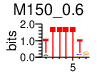

In [30]:
smeagol.visualize.plot_pwm(pwms, 'M150_0.6', 5)

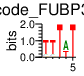

In [31]:
smeagol.visualize.plot_pwm(pwms, 'encode_FUBP3_2', 5)

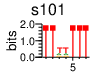

In [32]:
smeagol.visualize.plot_pwm(pwms, 's101', 5)

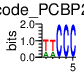

In [33]:
smeagol.visualize.plot_pwm(pwms, 'encode_PCBP2_2', 5)

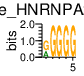

In [34]:
smeagol.visualize.plot_pwm(pwms, 'encode_HNRNPA2B1_1', 5)

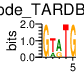

In [35]:
smeagol.visualize.plot_pwm(pwms, 'encode_TARDBP_1', 5)

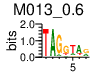

In [36]:
smeagol.visualize.plot_pwm(pwms, 'M013_0.6', 5)

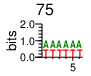

In [37]:
smeagol.visualize.plot_pwm(pwms, '75', 5)

### Novel findings

In [52]:
enr['binder'] = enr.RBP.isin(all_validated)
uenr['binder'] = uenr.RBP.isin(all_validated)
enr['in_crispr'] = enr.RBP.isin(all_crispr)
uenr['in_crispr'] = uenr.RBP.isin(all_crispr)
enr['proviral'] = enr.RBP.isin(all_pv)
enr['antiviral'] = enr.RBP.isin(all_av)
uenr['proviral'] = uenr.RBP.isin(all_pv)
uenr['antiviral'] = uenr.RBP.isin(all_av)

In [55]:
# RBPs which are clearly enriched, not found in screens
enr_novel_hits = enr[(enr.sense=='+') & (enr.sig05) & (enr.dir=='up') & (enr.fc >= 2) & \
                    (~enr.in_crispr) & (~enr.RBP.isin(all_dn))]
enr_novel_hits[['RBP', 'Matrix_id', 'num', 'avg', 'fc', 'binder']]

,RBP,Matrix_id,num,avg,fc,binder
340,SRSF2,s57,4.0,0.341,11.730205,False


In [77]:
uenr_novel_hits = uenr[(uenr.sig05) & (uenr.dir=='up') & (uenr.fc >= 2) & \
                 (~uenr.in_crispr) & (~uenr.RBP.isin(all_dn1))]
uenr_novel_hits[['RBP', 'Matrix_id', 'region', 'num', 'avg', 'fc', 'binder']]

,RBP,Matrix_id,region,num,avg,fc,binder
25857,SART3,M062_0.6,three_prime_UTR,28.0,1.951,14.351615,False
25875,PABPC1,M146_0.6,three_prime_UTR,28.0,1.951,14.351615,True
25927,NUPL2,encode_NUPL2_1,three_prime_UTR,27.0,2.540,10.629921,False
26449,ZRANB2,s21,five_prime_UTR,4.0,0.248,16.129032,False


In [78]:
#Clearly Depleted, not found in screens
dep_novel_hits = enr[(enr.sense=='+') & (enr.sig05) & (enr.dir=='dn') & (enr.fc <= 0.5) &
               (~enr.in_crispr) & (~enr.RBP.isin(all_up1))]
dep_novel_hits[['RBP', 'Matrix_id', 'num', 'avg', 'fc', 'binder']]

,RBP,Matrix_id,num,avg,fc,binder
32,HNRNPK,encode_HNRNPK_1,3.0,11.533,0.260123,False
166,U2AF2,M077_0.6,14.0,30.452,0.459740,False
192,RBFOX2,encode_RBFOX2_1,15.0,31.152,0.481510,False
194,RBFOX3,encode_RBFOX3_1,15.0,31.152,0.481510,False
450,HNRNPC,M025_0.6,17.0,43.979,0.386548,True
500,CPEB4,M149_0.6,6.0,40.491,0.148181,True
506,HNRNPCL1,M158_0.6,17.0,43.979,0.386548,False
508,RBFOX1,M159_0.6,7.0,18.076,0.387254,False
574,RBM25,encode_RBM25_1,10.0,25.282,0.395538,False
618,HNRNPA1,s32,9.0,23.545,0.382247,True


In [61]:
set(dep_novel_hits.RBP)

{'CPEB4',
 'HNRNPA1',
 'HNRNPC',
 'HNRNPCL1',
 'HNRNPK',
 'MSI1',
 'RBFOX1',
 'RBFOX2',
 'RBFOX3',
 'RBM25',
 'U2AF2'}

### Compare to other coronaviruses

In [62]:
cov_pos_up = set(cov_enr.RBP[(cov_enr.sig05) & (cov_enr.sense=='+') & (cov_enr.dir=='up')])
cov_pos_dn = set(cov_enr.RBP[(cov_enr.sig05) & (cov_enr.sense=='+') & (cov_enr.dir=='dn')])
cov_neg_up = set(cov_enr.RBP[(cov_enr.sig05) & (cov_enr.sense=='-') & (cov_enr.dir=='up')])
cov_neg_dn = set(cov_enr.RBP[(cov_enr.sig05) & (cov_enr.sense=='-') & (cov_enr.dir=='dn')])

In [63]:
print(pos_up.difference(cov_pos_up))
print(pos_dn.difference(cov_pos_dn))
print(neg_up.difference(cov_neg_up))
print(neg_dn.difference(cov_neg_dn))

{'YBX1'}
set()
{'SFPQ'}
{'ZCRB1'}


In [64]:
set(['YBX1', 'SFPQ', 'ZCRB1']).intersection(all_validated)

{'YBX1'}

In [65]:
enr.loc[(enr.Gene_name=='YBX1') & (enr.sig05), 
        ['RBP', 'Matrix_id', 'num', 'avg', 'fc', 'binder']]

,RBP,Matrix_id,num,avg,fc,binder
106,YBX1,s54,193.0,155.690,1.239643,True
107,YBX1,s54,327.0,212.420,1.539403,True
277,YBX1,M081_0.6,34.0,16.007,2.124071,True
489,YBX1,M111_0.6,51.0,18.646,2.735171,True


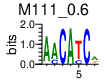

In [66]:
smeagol.visualize.plot_pwm(pwms, 'M111_0.6', 6)

## Analyze variant effects

In [79]:
# Select PWMs based on the following criteria:
## (Clearly, strongly depleted novel hits OR antiviral with predicted sites on the + genome)
## AND fewer than 10 binding sites on the + sense genome

strong_dep_mats = set(dep_novel_hits.Matrix_id[dep_novel_hits.fc <= .5])
av_with_sites_mats = set(enr.Matrix_id[(enr.antiviral) & (enr.sense=='+') & (~enr.proviral)])
few_sites_mats = set(enr.Matrix_id[(enr.sense=='+') & (enr.num<10) & (enr.num>0)])

select_mats = (strong_dep_mats.union(av_with_sites_mats)).intersection(few_sites_mats)

In [80]:
enr.loc[(enr.Matrix_id.isin(select_mats)) & (enr.sense=='+'),
   ['RBP', 'Matrix_id', 'num', 'avg', 'fc', 'binder', 'antiviral', 'in_crispr']]

,RBP,Matrix_id,num,avg,fc,binder,antiviral,in_crispr
32,HNRNPK,encode_HNRNPK_1,3.0,11.533,0.260123,False,False,False
242,SRSF7,M071_0.6,2.0,0.789,2.534854,False,True,True
368,ELAVL1,M232_0.6,4.0,24.444,0.163639,True,True,True
402,PCBP2,M043_0.6,4.0,3.863,1.035465,True,True,True
442,DAZAP1,M013_0.6,3.0,10.388,0.288795,True,True,True
448,HNRNPA2B1,M024_0.6,3.0,9.866,0.304075,True,True,True
500,CPEB4,M149_0.6,6.0,40.491,0.148181,True,False,False
502,RALY,M150_0.6,5.0,30.350,0.164745,True,True,True
508,RBFOX1,M159_0.6,7.0,18.076,0.387254,False,False,False
548,HNRNPA2B1,encode_HNRNPA2B1_1,8.0,18.240,0.438596,True,True,True


In [81]:
select_mats.remove('M024_0.6')

In [82]:
select_mats

{'M013_0.6',
 'M043_0.6',
 'M071_0.6',
 'M149_0.6',
 'M150_0.6',
 'M159_0.6',
 'M232_0.6',
 'encode_HNRNPA2B1_1',
 'encode_HNRNPK_1',
 's32'}

In [83]:
len(select_mats)

10

In [84]:
set(pwms.Gene_name[pwms.Matrix_id.isin(select_mats)]).intersection(all_av)

{'DAZAP1', 'ELAVL1', 'HNRNPA2B1', 'PCBP2', 'RALY', 'SRSF7'}

In [85]:
select_sites = sites[(sites.Matrix_id.isin(select_mats)) & (sites.sense=='+')]
select_sites.reset_index(drop=True, inplace=True)
len(select_sites)

51

In [86]:
select_pwms = pwms[pwms.Matrix_id.isin(select_mats)]
select_pwms.reset_index(drop=True, inplace=True)

In [87]:
# Load mutations from GESS
all_var = pd.read_csv('../../sars-cov-2/SNV_till20210507_uniq.tsv', sep='\t')

In [88]:
all_var.rename(columns={'alteration': 'alt', 'position':'pos'}, inplace=True)
all_var['name'] = 'NC_045512.2'

In [89]:
len(all_var)

36688

In [80]:
all_var.head(3)

,SNV,pos,reference,alt,annotations,location,associated gene,AA,number of samples carrying the SNV,name
0,A23403G,23403,A,G,nonsynonymous_SNV,exonic,S,S:YP_009724390.1:exon1:c.A1841G:p.D614G,143449,NC_045512.2
1,C3037T,3037,C,T,synonymous_SNV,exonic,ORF1a ORF1ab nsp3,"ORF1ab:YP_009724389.1:exon1:c.C2772T:p.F924F,O...",143410,NC_045512.2
2,C14408T,14408,C,T,nonsynonymous_SNV,exonic,ORF1ab nsp12,ORF1ab:YP_009724389.1:exon2:c.C14144T:p.P4715L...,143343,NC_045512.2


In [82]:
effects = smeagol.variant.variant_effect_on_sites(select_sites, all_var, genome, select_pwms)
effects.head(3)

,SNV,pos,reference,alt,annotations,location,associated gene,AA,number of samples carrying the SNV,name,...,start,Matrix_id,width,end,Gene_name,source,seq,max_score,score,variant_score
0,C19T,19,C,T,.,upstream,ORF1a ORF1ab nsp1 nsp2,.,39,NC_045512.2,...,14,M043_0.6,7,21,PCBP2,Attract,CCTTCCC,10.539042,1.0,0.500554
1,C20A,20,C,A,.,upstream,ORF1a ORF1ab nsp1 nsp2,.,35,NC_045512.2,...,14,M043_0.6,7,21,PCBP2,Attract,CCTTCCC,10.539042,1.0,0.811619
2,T18G,18,T,G,.,upstream,ORF1a ORF1ab nsp1 nsp2,.,29,NC_045512.2,...,14,M043_0.6,7,21,PCBP2,Attract,CCTTCCC,10.539042,1.0,0.532421


In [87]:
escape = effects[effects.variant_score<.5].copy().reset_index(drop=True)
print(len(escape))
escape.head(3)

221


,SNV,pos,reference,alt,annotations,location,associated gene,AA,number of samples carrying the SNV,name,...,start,Matrix_id,width,end,Gene_name,source,seq,max_score,score,variant_score
0,C12119T,12119,C,T,nonsynonymous_SNV,exonic,ORF1a ORF1ab nsp8,ORF1ab:YP_009724389.1:exon1:c.C11854T:p.P3952S...,1633,NC_045512.2,...,12114,M043_0.6,7,12121,PCBP2,Attract,CCTTCCA,10.539042,0.811619,0.312172
1,T12118G,12118,T,G,synonymous_SNV,exonic,ORF1a ORF1ab nsp8,ORF1ab:YP_009724389.1:exon1:c.T11853G:p.L3951L...,5,NC_045512.2,...,12114,M043_0.6,7,12121,PCBP2,Attract,CCTTCCA,10.539042,0.811619,0.34404
2,C12116A,12116,C,A,nonsynonymous_SNV,exonic,ORF1a ORF1ab nsp8,ORF1ab:YP_009724389.1:exon1:c.C11851A:p.L3951I...,3,NC_045512.2,...,12114,M043_0.6,7,12121,PCBP2,Attract,CCTTCCA,10.539042,0.811619,0.362891


In [89]:
escape.drop(columns=['max_score', 'number of samples carrying the SNV', 'AA', 'id', 'width'], 
            inplace=True)

In [91]:
escape.rename(columns={'Gene_name': 'RBP'}, inplace=True)

In [92]:
escape.head()

,SNV,pos,reference,alt,annotations,location,associated gene,name,sense,start,Matrix_id,end,RBP,source,seq,score,variant_score
0,C12119T,12119,C,T,nonsynonymous_SNV,exonic,ORF1a ORF1ab nsp8,NC_045512.2,+,12114,M043_0.6,12121,PCBP2,Attract,CCTTCCA,0.811619,0.312172
1,T12118G,12118,T,G,synonymous_SNV,exonic,ORF1a ORF1ab nsp8,NC_045512.2,+,12114,M043_0.6,12121,PCBP2,Attract,CCTTCCA,0.811619,0.34404
2,C12116A,12116,C,A,nonsynonymous_SNV,exonic,ORF1a ORF1ab nsp8,NC_045512.2,+,12114,M043_0.6,12121,PCBP2,Attract,CCTTCCA,0.811619,0.362891
3,C15928T,15928,C,T,nonsynonymous_SNV,exonic,ORF1ab nsp12,NC_045512.2,+,15923,M043_0.6,15930,PCBP2,Attract,CCTTCCT,0.803144,0.303697
4,T15927G,15927,T,G,synonymous_SNV,exonic,ORF1ab,NC_045512.2,+,15923,M043_0.6,15930,PCBP2,Attract,CCTTCCT,0.803144,0.335565


In [93]:
escape.to_csv('../RESULTS/sarscov2_escape_variants.tsv', sep='\t', index=False)

In [97]:
escape_snvs = escape[['SNV', 'location', 'annotations']].drop_duplicates()
len(escape_snvs)

170

In [98]:
escape_snvs.location.value_counts()

exonic        148
downstream     14
upstream        8
Name: location, dtype: int64

In [99]:
escape_snvs.annotations.value_counts()

nonsynonymous_SNV             78
synonymous_SNV                60
.                             22
nonframeshift_substitution     6
stopgain                       4
Name: annotations, dtype: int64

In [101]:
escape.RBP.value_counts()

HNRNPA1      42
HNRNPA2B1    40
CPEB4        29
RBFOX1       27
RALY         24
ELAVL1       18
HNRNPK       16
DAZAP1        9
PCBP2         8
SRSF7         8
Name: RBP, dtype: int64

## Focus on position 11078

In [405]:
select_sites = select_sites[(select_sites.start <= 11078) & (select_sites.end >= 11078)].reset_index(drop=True)

In [425]:
select_var = all_var.loc[all_var.pos==11078, ['SNV', 'pos', 'reference', 'alt', 'name']]

In [427]:
select_var = pd.concat([select_var, 
   pd.DataFrame.from_dict({'SNV':'T11078A','pos':11078,'reference':'T','alt':'A', 'name':'NC_045512.2'}, orient='index').T]).reset_index(drop=True)

In [428]:
e = smeagol.variant.variant_effect_on_sites(select_sites, select_var, genome, select_pwms)

In [429]:
e['diff'] = e.variant_score - e.score

In [430]:
e = e[e.Matrix_id.isin(reps)]

In [434]:
e = e[['SNV', 'alt', 'Matrix_id', 'Gene_name', 'score', 'diff']].drop_duplicates().sort_values('alt').reset_index(drop=True)

In [435]:
e = e.groupby(['SNV', 'alt', 'Gene_name']).max('diff').reset_index()

In [436]:
e

,SNV,alt,Gene_name,Matrix_id,score,diff
0,T11078A,A,CPEB4,M149_0.6,1.0,-0.583037
1,T11078A,A,ELAVL1,M232_0.6,1.0,-0.251782
2,T11078A,A,RALY,M150_0.6,1.0,-0.590492
3,T11078C,C,CPEB4,M149_0.6,1.0,-0.583037
4,T11078C,C,ELAVL1,M232_0.6,1.0,-0.527136
5,T11078C,C,RALY,M150_0.6,1.0,-0.590492
6,T11078G,G,CPEB4,M149_0.6,1.0,-0.271968
7,T11078G,G,ELAVL1,M232_0.6,1.0,-0.253643
8,T11078G,G,RALY,M150_0.6,1.0,-0.590492


In [437]:
colors = {'C': 'b', 'G': 'r', 'A':'y'}

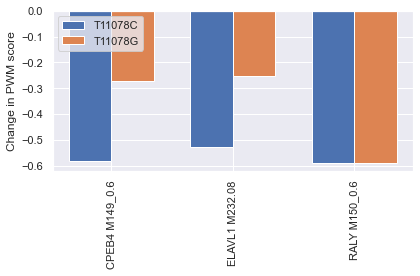

In [449]:
fig, ax = plt.subplots()
width = 0.35
x = np.arange(3) 
rects1 = ax.bar(x - width/2, e.loc[e.alt=='C', 'diff'], width, label='T11078C')
rects2 = ax.bar(x + width/2, e.loc[e.alt=='G', 'diff'], width, label='T11078G')
ax.set_xticks(x)
ax.set_xticklabels(['CPEB4 M149_0.6', 'ELAVL1 M232.08', 'RALY M150_0.6'])
plt.xticks(rotation = 90)
ax.legend(loc=2)
ax.set_ylabel('Change in PWM score')
fig.tight_layout()
plt.show()

## Visualize binding site distribution

In [178]:
simple_pwms = pd.read_csv('../RESULTS/simple_pwms.tsv', sep='\t')

In [125]:
enr.loc[(enr.sig05) & (enr.sense=='+') & (enr.dir=='dn') & (enr.RBP.isin(all_validated)), 
        ['Matrix_id', 'RBP', 'num']]

,Matrix_id,RBP,num
54,M075_0.6,TIA1,19.0
154,encode_TIA1_1,TIA1,151.0
162,s35,HNRNPDL,153.0
178,M156_0.6,TIA1,14.0
190,encode_PUM1_1,PUM1,163.0
292,encode_FUBP3_2,FUBP3,136.0
324,s101,ELAVL1,28.0
368,M232_0.6,ELAVL1,4.0
372,encode_HNRNPC_1,HNRNPC,61.0
382,s13,HNRNPC,61.0


In [176]:
enr.loc[(enr.sig05) & (enr.sense=='+') & (enr.dir=='dn') & (enr.RBP.isin(all_validated)), 
        ['Matrix_id', 'RBP']]

,Matrix_id,RBP
54,M075_0.6,TIA1
154,encode_TIA1_1,TIA1
162,s35,HNRNPDL
178,M156_0.6,TIA1
190,encode_PUM1_1,PUM1
292,encode_FUBP3_2,FUBP3
324,s101,ELAVL1
368,M232_0.6,ELAVL1
372,encode_HNRNPC_1,HNRNPC
382,s13,HNRNPC


In [452]:
urich_dn = enr.loc[(enr.sig05) & (enr.sense=='+') & (enr.dir=='dn') & \
        (enr.RBP.isin(all_validated)) & \
        (enr.Matrix_id.isin(simple_pwms.Matrix_id[simple_pwms.nucleotide=='T'])), 
        ['Matrix_id', 'RBP', 'num', 'avg', 'log2fc', 'fdr']]
urich_dn

,Matrix_id,RBP,num,avg,log2fc,fdr
54,M075_0.6,TIA1,19.0,39.727,-1.064120,4.838637e-03
154,encode_TIA1_1,TIA1,151.0,210.945,-0.482318,2.414811e-04
178,M156_0.6,TIA1,14.0,38.461,-1.457969,2.014964e-04
292,encode_FUBP3_2,FUBP3,136.0,189.379,-0.477670,6.844312e-04
324,s101,ELAVL1,28.0,51.108,-0.868122,5.822497e-03
368,M232_0.6,ELAVL1,4.0,24.444,-2.611408,3.224926e-05
372,encode_HNRNPC_1,HNRNPC,61.0,121.035,-0.988543,1.903129e-07
382,s13,HNRNPC,61.0,121.035,-0.988543,1.903129e-07
450,M025_0.6,HNRNPC,17.0,43.979,-1.371280,1.518037e-04
500,M149_0.6,CPEB4,6.0,40.491,-2.754567,5.799540e-09


In [485]:
enr.loc[(enr.sense=='+') & (enr.log2fc<(-2)) & (enr.fdr<0.05),
   ['Matrix_id', 'RBP', 'num', 'avg', 'log2fc', 'fdr']]

,Matrix_id,RBP,num,avg,log2fc,fdr
368,M232_0.6,ELAVL1,4.0,24.444,-2.611408,3.224926e-05
500,M149_0.6,CPEB4,6.0,40.491,-2.754567,5.799540e-09
502,M150_0.6,RALY,5.0,30.350,-2.601697,1.865037e-06


In [453]:
urich_dn[urich_dn.Matrix_id.isin(reps)]

,Matrix_id,RBP,num,avg,log2fc,fdr
292,encode_FUBP3_2,FUBP3,136.0,189.379,-0.477670,6.844312e-04
368,M232_0.6,ELAVL1,4.0,24.444,-2.611408,3.224926e-05
382,s13,HNRNPC,61.0,121.035,-0.988543,1.903129e-07
500,M149_0.6,CPEB4,6.0,40.491,-2.754567,5.799540e-09
502,M150_0.6,RALY,5.0,30.350,-2.601697,1.865037e-06


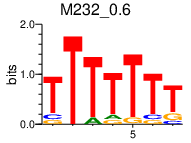

In [251]:
smeagol.visualize.plot_pwm(pwms, 'M232_0.6')

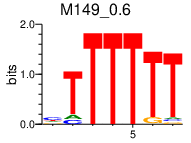

In [247]:
smeagol.visualize.plot_pwm(pwms, 'M149_0.6')

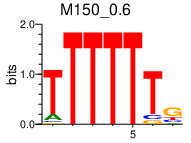

In [248]:
smeagol.visualize.plot_pwm(pwms, 'M150_0.6')

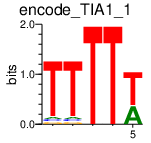

In [249]:
smeagol.visualize.plot_pwm(pwms, 'encode_TIA1_1')

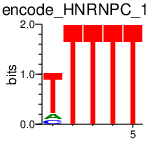

In [252]:
smeagol.visualize.plot_pwm(pwms, 'encode_HNRNPC_1')

In [323]:
sns.set_theme()

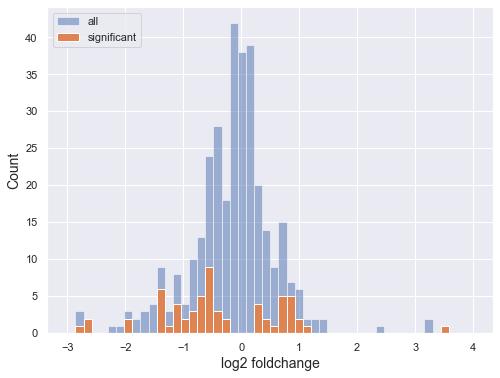

In [465]:
plt.figure(figsize=(8,6))
plt.hist(enr_to_plot.log2fc, range=[-3, 4], bins=50, alpha = 0.5, 
         label='all')
plt.hist(enr_to_plot.log2fc[enr_to_plot.sig05], range=[-3, 4], bins=50, 
         alpha = 1.0, label='significant')
plt.xlabel("log2 foldchange", size=14)
plt.ylabel("Count", size=14)
plt.legend(loc='upper left')
plt.savefig("../RESULTS/SARSCoV2_foldchanges_hist.pdf")
plt.show()

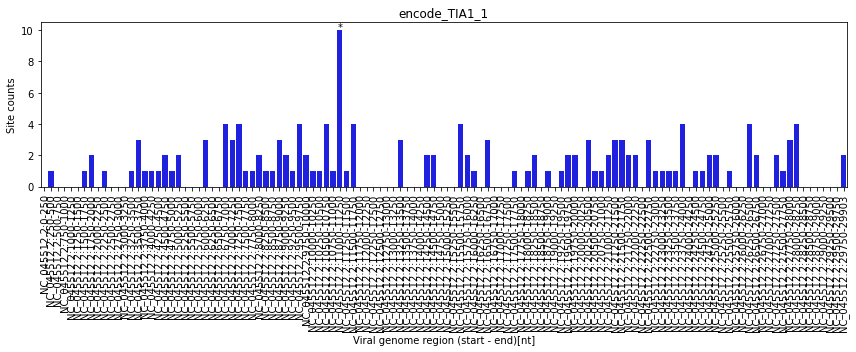

In [250]:
mat='encode_TIA1_1'
r = smeagol.enrich.enrich_in_sliding_windows(sites[sites.sense=="+"], genome, mat, 250)

r['window'] = r.index
r['sig'] = r.padj<0.05
r['window_name'] = r.apply(lambda row: row.id + ':' + str(row.start) + '-' + str(row.end), axis=1)
smeagol.visualize.sliding_window_enrichment_plot(sliding_window_df=r, x_var='window', 
                        y_var='count', xticklabels='window_name', title=mat)

In [468]:
mat='M150_0.6'
r = smeagol.enrich.enrich_in_sliding_windows(sites[sites.sense=="+"], genome, mat, 500)

r['window'] = r.index
r['sig'] = r.padj<0.05
r['window_name'] = r.apply(lambda row: row.id + ':' + str(row.start) + '-' + str(row.end), axis=1)

In [ ]:
smeagol.visualize.sliding_window_enrichment_plot(sliding_window_df=r, x_var='window', 
                        y_var='count', xticklabels='window_name', 
                        title=mat + ' (RALY) counts per genome window',
                        file_path='../RESULTS/SARSCoV2_RALY_window_plot.pdf')

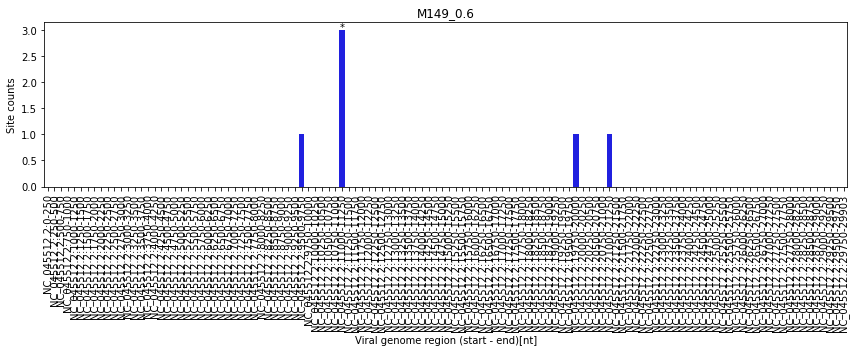

In [221]:
mat='M149_0.6'
r = smeagol.enrich.enrich_in_sliding_windows(sites[sites.sense=="+"], genome, mat, 250)

r['window'] = r.index
r['sig'] = r.padj<0.05
r['window_name'] = r.apply(lambda row: row.id + ':' + str(row.start) + '-' + str(row.end), axis=1)
smeagol.visualize.sliding_window_enrichment_plot(sliding_window_df=r, x_var='window', 
                        y_var='count', xticklabels='window_name', title=mat)

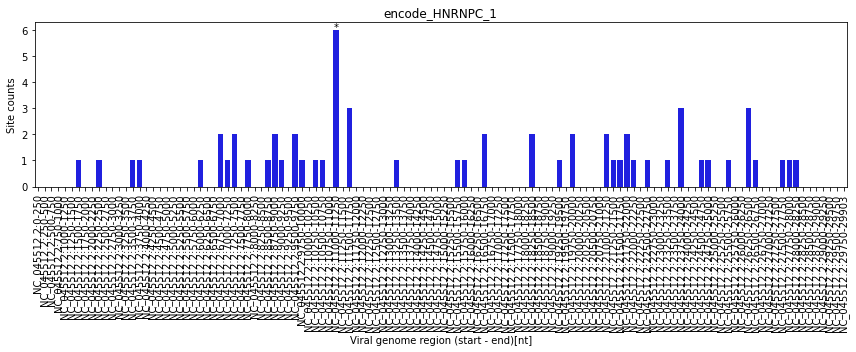

In [220]:
mat='encode_HNRNPC_1'
r = smeagol.enrich.enrich_in_sliding_windows(sites[sites.sense=="+"], genome, mat, 250)

r['window'] = r.index
r['sig'] = r.padj<0.05
r['window_name'] = r.apply(lambda row: row.id + ':' + str(row.start) + '-' + str(row.end), axis=1)
smeagol.visualize.sliding_window_enrichment_plot(sliding_window_df=r, x_var='window', 
                        y_var='count', xticklabels='window_name', title=mat)

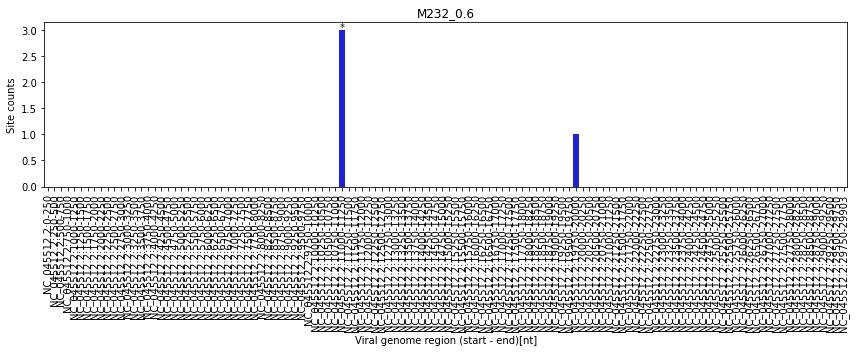

In [219]:
mat='M232_0.6'
r = smeagol.enrich.enrich_in_sliding_windows(sites[sites.sense=="+"], genome, mat, 250)

r['window'] = r.index
r['sig'] = r.padj<0.05
r['window_name'] = r.apply(lambda row: row.id + ':' + str(row.start) + '-' + str(row.end), axis=1)
smeagol.visualize.sliding_window_enrichment_plot(sliding_window_df=r, x_var='window', 
                        y_var='count', xticklabels='window_name', title=mat)

In [472]:
genome[0].seq[11070:11086].__str__().replace('T', 'U')

'GUUCUUUUUUUUGUAU'

In [461]:
sites[(sites.Gene_name=='RALY') & (sites.sense=='+')]

,id,name,sense,start,Matrix_id,width,end,Gene_name,source
45999,NC_045512.2,NC_045512.2,+,11074,M150_0.6,7,11081,RALY,Attract
46000,NC_045512.2,NC_045512.2,+,11075,M150_0.6,7,11082,RALY,Attract
46001,NC_045512.2,NC_045512.2,+,11076,M150_0.6,7,11083,RALY,Attract
46002,NC_045512.2,NC_045512.2,+,19983,M150_0.6,7,19990,RALY,Attract
46003,NC_045512.2,NC_045512.2,+,21101,M150_0.6,7,21108,RALY,Attract


In [463]:
sites[(sites.Matrix_id=='M232_0.6') & (sites.sense=='+')]

,id,name,sense,start,Matrix_id,width,end,Gene_name,source
45967,NC_045512.2,NC_045512.2,+,11074,M232_0.6,7,11081,ELAVL1,Attract
45968,NC_045512.2,NC_045512.2,+,11075,M232_0.6,7,11082,ELAVL1,Attract
45969,NC_045512.2,NC_045512.2,+,11076,M232_0.6,7,11083,ELAVL1,Attract
45970,NC_045512.2,NC_045512.2,+,19983,M232_0.6,7,19990,ELAVL1,Attract


In [464]:
sites[(sites.Gene_name=='CPEB4') & (sites.sense=='+')]

,id,name,sense,start,Matrix_id,width,end,Gene_name,source
45932,NC_045512.2,NC_045512.2,+,9626,M149_0.6,7,9633,CPEB4,Attract
45933,NC_045512.2,NC_045512.2,+,11073,M149_0.6,7,11080,CPEB4,Attract
45934,NC_045512.2,NC_045512.2,+,11074,M149_0.6,7,11081,CPEB4,Attract
45935,NC_045512.2,NC_045512.2,+,11075,M149_0.6,7,11082,CPEB4,Attract
45936,NC_045512.2,NC_045512.2,+,19982,M149_0.6,7,19989,CPEB4,Attract
45937,NC_045512.2,NC_045512.2,+,21100,M149_0.6,7,21107,CPEB4,Attract


In [172]:
gff = pd.read_csv('../DATA/Genomes/Genomes/IV/Monopartite/Coronaviridae/GCF_009858895.2/GCF_009858895.2_ASM985889v3_genomic.gff.gz',
                 compression='gzip', sep='\t', skiprows=7, header=None)

In [173]:
gff

,0,1,2,3,4,5,6,7,8
0,NC_045512.2,RefSeq,region,1.0,29903.0,.,+,.,ID=NC_045512.2:1..29903;Dbxref=taxon:2697049;c...
1,NC_045512.2,RefSeq,five_prime_UTR,1.0,265.0,.,+,.,ID=id-NC_045512.2:1..265;gbkey=5'UTR
2,NC_045512.2,RefSeq,gene,266.0,21555.0,.,+,.,ID=gene-GU280_gp01;Dbxref=GeneID:43740578;Name...
3,NC_045512.2,RefSeq,CDS,266.0,13468.0,.,+,0,ID=cds-YP_009724389.1;Parent=gene-GU280_gp01;D...
4,NC_045512.2,RefSeq,CDS,13468.0,21555.0,.,+,0,ID=cds-YP_009724389.1;Parent=gene-GU280_gp01;D...
5,NC_045512.2,RefSeq,mature_protein_region_of_CDS,266.0,805.0,.,+,.,ID=id-YP_009724389.1:1..180;Note=nsp1%3B produ...
6,NC_045512.2,RefSeq,mature_protein_region_of_CDS,806.0,2719.0,.,+,.,ID=id-YP_009724389.1:181..818;Note=produced by...
7,NC_045512.2,RefSeq,mature_protein_region_of_CDS,2720.0,8554.0,.,+,.,ID=id-YP_009724389.1:819..2763;Note=former nsp...
8,NC_045512.2,RefSeq,mature_protein_region_of_CDS,8555.0,10054.0,.,+,.,ID=id-YP_009724389.1:2764..3263;Note=nsp4B_TM%...
9,NC_045512.2,RefSeq,mature_protein_region_of_CDS,10055.0,10972.0,.,+,.,ID=id-YP_009724389.1:3264..3569;Note=nsp5A_3CL...
